In [1]:

%pylab inline
import illustris_python as il 
from sklearn.neural_network import MLPRegressor 
from sklearn.datasets import make_regression 
from sklearn.model_selection  import train_test_split 

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
 
from sklearn.model_selection import train_test_split 
from sklearn.neural_network import MLPRegressor
#from halotools_ia.correlation_functions  import ed_3d,ee_3d, ed_3d_one_two_halo_decomp


Populating the interactive namespace from numpy and matplotlib


In [87]:
%pylab inline
#%load_ext autoreload
#%autoreload 2
import os
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import sys
sys.path.insert(0, '..')
import tensorflow as tf
 
 
from functools import partial
print(" Available: ",  (tf.config.list_physical_devices('GPU')))
from tensorflow.keras import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
import keras.backend as K

Populating the interactive namespace from numpy and matplotlib


 Available:  []


In [113]:
import tensorflow_probability as tfp
# data iformation
input_dim = 9 # number of input features
number_of_classes = 3 # number of classes
 # initial hyperparameters
dense_1_size = 32
dense_2_size = 16
learning_rate = 0.05

# define model architecture
model = Sequential()
model.add(Dense(dense_1_size, activation="relu", input_dim=input_dim))
model.add(Dense(dense_2_size, activation="relu"))
model.add(Dense(3))
#print(model.layers[2].output)
#model.add(tfp.distributions.PowerSpherical(model.layers[2].output, [1,1]))
model.add(Lambda(lambda x: tfp.distributions.PowerSpherical(x, [1])))

print(model.layers[3].output)
#model.add(Lambda(lambda x: K.l2_normalize(x, axis=-1)))
# compile the model
opt = Adam(learning_rate=learning_rate)

negative_log_likelihood = lambda y, q: -q.log_prob(y)

model.compile( loss=negative_log_likelihood, optimizer=opt)

KerasTensor(type_spec=PowerSpherical_ACTTypeSpec(3, {'mean_direction': TensorSpec(shape=(None, 3), dtype=tf.float32, name=None), 'concentration': TensorSpec(shape=(1,), dtype=tf.float32, name=None)}, {'validate_args': False, 'allow_nan_stats': True, 'name': 'PowerSpherical'}, ('parameters',), (), ('name',), {}), name='PowerSpherical', description="created by layer 'lambda_24'")


In [114]:
import pickle
from astropy.table import Table, join
from pandas import *

tng = pickle.load(  open('/hildafs/projects/phy200017p/yjagvara/some_data/TNG100-1_99_non-reduced_galaxy_shapes_multi_scale_256.pkl', "rb" ) )

tng = Table.from_pandas(DataFrame(tng))
tng = tng[tng['dm_mass']>0]
#tng = tng[tng['central_bool']>0]
tid_av_x_train, tid_av_x_test,\
tid_av_y_train, tid_av_y_test,\
tid_av_z_train, tid_av_z_test,\
tid_bv_x_train,tid_bv_x_test,\
tid_bv_y_train, tid_bv_y_test,\
tid_bv_z_train, tid_bv_z_test,\
tid_cv_x_train, tid_cv_x_test,\
tid_cv_y_train, tid_cv_y_test,\
tid_cv_z_train, tid_cv_z_test,\
dm_av_x_train,  dm_av_x_test,\
dm_av_y_train,  dm_av_y_test,\
dm_av_z_train, dm_av_z_test,\
gal_pos_x_train, gal_pos_x_test,\
gal_pos_y_train, gal_pos_y_test,\
gal_pos_z_train, gal_pos_z_test = train_test_split( (tng['tid_av_x_0.1_256']),  (tng['tid_av_y_0.1_256']),  (tng['tid_av_z_0.1_256']),
                                        (tng['tid_bv_x_0.1_256']),  (tng['tid_bv_y_0.1_256']),  (tng['tid_bv_z_0.1_256']),
                                       ( tng['tid_cv_x_0.1_256']),  (tng['tid_cv_y_0.1_256']),  (tng['tid_cv_z_0.1_256']),
                                               (tng['dm_av_x']),   (tng['dm_av_y']),   (tng['dm_av_z']),
                                                tng['gal_pos_x'], tng['gal_pos_y'], tng['gal_pos_z'],random_state=0,test_size=0.5)
 
# subhalo_mass_train=subhalo_mass_train.reshape(-1,1)
# subhalo_mass_test=subhalo_mass_test.reshape(-1,1)
# stellar_mass_train=stellar_mass_train.reshape(-1,1)

X = np.vstack((tid_av_x_train, tid_av_y_train, tid_av_z_train, \
tid_bv_x_train, tid_bv_y_train, tid_bv_z_train, \
tid_cv_x_train, tid_cv_y_train, tid_cv_z_train)).T
Y = np.vstack((dm_av_x_train, dm_av_y_train,   dm_av_z_train)).T

X_test = np.vstack((tid_av_x_test, tid_av_y_test, tid_av_z_test, \
tid_bv_x_test, tid_bv_y_test, tid_bv_z_test, \
tid_cv_x_test, tid_cv_y_test, tid_cv_z_test)).T
Y_test = np.vstack((dm_av_x_test, dm_av_y_test,   dm_av_z_test)).T

In [115]:
batch_size = min(200, np.array(tng).shape[0])
epochs = 500
      
stratify =   None
# X_train, X_vald, y_train, y_vald = train_test_split(
#     X, y, test_size=0.1, shuffle=True, stratify=stratify
# )
# set callbacks
es = EarlyStopping(monitor="val_loss", mode="min", verbose=0, patience=10)
mc = ModelCheckpoint(
    "best_model.h5",
    monitor="val_loss",
    mode="min",
    verbose=0,
    save_best_only=True,
)

model.fit(
    X,
    Y,
    validation_data=(X_test, Y_test),
    batch_size=batch_size,
    epochs=500,
    verbose=False,
    callbacks=[es, mc],
)

In [116]:
x_smpl = linspace((-1,-1,-1), (1,1,1),1000)
[print(x) for x in x_smpl]

[-1. -1. -1.]
[-0.997998 -0.997998 -0.997998]
[-0.995996 -0.995996 -0.995996]
[-0.99399399 -0.99399399 -0.99399399]
[-0.99199199 -0.99199199 -0.99199199]
[-0.98998999 -0.98998999 -0.98998999]
[-0.98798799 -0.98798799 -0.98798799]
[-0.98598599 -0.98598599 -0.98598599]
[-0.98398398 -0.98398398 -0.98398398]
[-0.98198198 -0.98198198 -0.98198198]
[-0.97997998 -0.97997998 -0.97997998]
[-0.97797798 -0.97797798 -0.97797798]
[-0.97597598 -0.97597598 -0.97597598]
[-0.97397397 -0.97397397 -0.97397397]
[-0.97197197 -0.97197197 -0.97197197]
[-0.96996997 -0.96996997 -0.96996997]
[-0.96796797 -0.96796797 -0.96796797]
[-0.96596597 -0.96596597 -0.96596597]
[-0.96396396 -0.96396396 -0.96396396]
[-0.96196196 -0.96196196 -0.96196196]
[-0.95995996 -0.95995996 -0.95995996]
[-0.95795796 -0.95795796 -0.95795796]
[-0.95595596 -0.95595596 -0.95595596]
[-0.95395395 -0.95395395 -0.95395395]
[-0.95195195 -0.95195195 -0.95195195]
[-0.94994995 -0.94994995 -0.94994995]
[-0.94794795 -0.94794795 -0.94794795]
[-0.945945

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [117]:
print(model(X_test).log_prob([1,1,1 ]))

tf.Tensor([-3.119864  -3.119864  -3.119864  ... -3.0256858 -3.119864  -3.119864 ], shape=(25369,), dtype=float32)


In [118]:
#x_smpl = linspace((-1,-1,-1,-1,-1,-1,-1,-1,-1), (1,1,1,1,1,1,1,1,1),100)


# We evaluate the log probability of the model at different points, to sample the pdf of
# each example
preds = np.stack([model(X_test).log_prob(x).numpy() for x in x_smpl])
mode = x_smpl[preds.argmax(axis=0)]


In [119]:
print(preds.shape)

(1000, 25369)


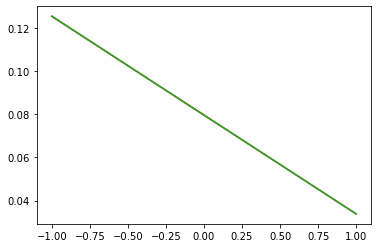

In [103]:
mode = mode.reshape(Y_test.shape)
from scipy.stats import lognorm
plot(x_smpl, exp(preds[:,2]))
plot(x_smpl, lognorm.pdf(x_smpl, s=X_test.flatten()[2], loc=2*X_test.flatten()[2]))

In [120]:
h=hist(Y_pred,bins=30)
xlabel('Predicted (Normalized)')

NameError: name 'Y_pred' is not defined

Text(0.5, 0, 'Actual (Normalized)')

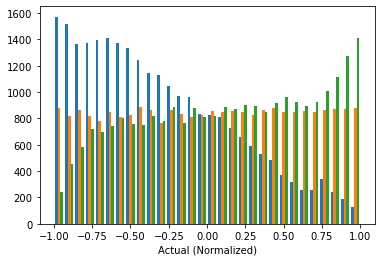

In [121]:
h=hist(Y_test,bins=30)
xlabel('Actual (Normalized)')

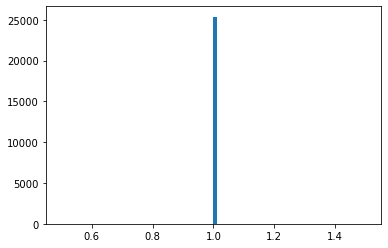

In [122]:
norms = np.linalg.norm(Y_test,axis=1).astype('float32')
h=hist(norms,bins=100 )


# dm_vecs = np.array([(tng['dm_av_x']),   (tng['dm_av_y']),   (tng['dm_av_z'])])
# zero_dm_vecs = dm_vecs.T[np.linalg.norm(dm_vecs,axis=0)<1]
# #hist(np.linalg.norm(zero_dm_vecs,axis=1).astype('float32'))




In [123]:
print(np.linalg.norm(Y,axis=-1) )


[1. 1. 1. ... 1. 1. 1.]


In [21]:

dm_av_x_pred = Y_pred[:,0]
dm_av_y_pred = Y_pred[:,1]
dm_av_z_pred = Y_pred[:,2]

(array([4455., 4179., 3947., 3315., 2762., 2360., 1776., 1168.,  851.,
         556.]),
 array([-9.99951265e-01, -7.99992850e-01, -6.00034435e-01, -4.00076020e-01,
        -2.00117605e-01, -1.59190136e-04,  1.99799225e-01,  3.99757640e-01,
         5.99716055e-01,  7.99674470e-01,  9.99632884e-01]),
 <a list of 10 Patch objects>)

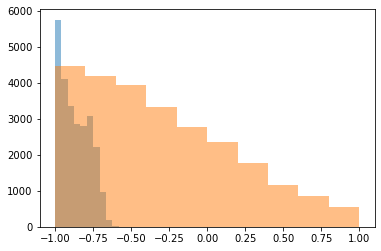

In [22]:
hist( (dm_av_x_pred),alpha=0.5)
hist( (dm_av_x_test),alpha=0.5)

(array([2560., 2451., 2521., 2489., 2468., 2566., 2541., 2576., 2568.,
        2629.]),
 array([-9.99868513e-01, -7.99901257e-01, -5.99934000e-01, -3.99966744e-01,
        -1.99999487e-01, -3.22302907e-05,  1.99935026e-01,  3.99902283e-01,
         5.99869540e-01,  7.99836796e-01,  9.99804053e-01]),
 <a list of 10 Patch objects>)

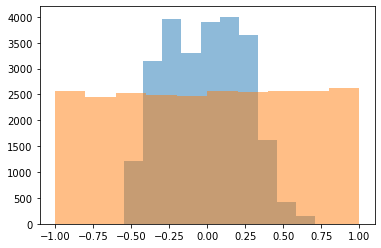

In [23]:
hist( (dm_av_y_pred),alpha=0.5)
hist( (dm_av_y_test),alpha=0.5)

(array([1283., 2163., 2312., 2489., 2455., 2582., 2647., 2806., 2831.,
        3801.]),
 array([-9.99847851e-01, -7.99865019e-01, -5.99882186e-01, -3.99899353e-01,
        -1.99916520e-01,  6.63128427e-05,  2.00049146e-01,  4.00031979e-01,
         6.00014811e-01,  7.99997644e-01,  9.99980477e-01]),
 <a list of 10 Patch objects>)

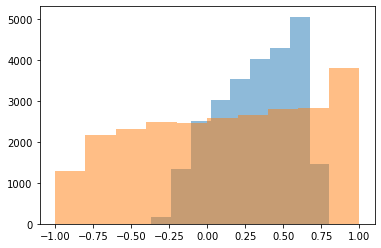

In [24]:
hist(dm_av_z_pred,alpha=0.5)
hist(dm_av_z_test,alpha=0.5)

Text(0.5, 1.0, 'Centrals only')

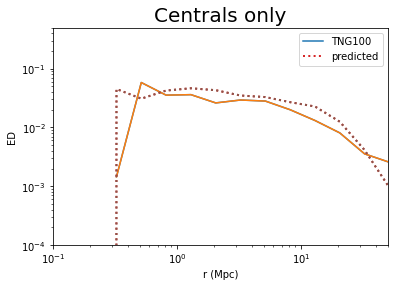

In [13]:
pos_train = np.array([gal_pos_x_train, gal_pos_y_train, gal_pos_z_train]).T
pos_test = np.array([gal_pos_x_test, gal_pos_y_test, gal_pos_z_test]).T

or_train = np.array([dm_av_x_train, dm_av_y_train, dm_av_z_train]).T 
or_pred = np.array([dm_av_x_pred, dm_av_y_pred, dm_av_z_pred]).T 
rbins = np.logspace(-1.5,1.5,16)
ed1h,ed2h = ed_3d_one_two_halo_decomp(pos_train , or_train , np.ones(len(or_train)),  pos_train , np.ones(len(or_train)) , rbins, period=None, num_threads=28)
ed1h2,ed2h2 = ed_3d_one_two_halo_decomp(pos_test , or_pred , np.ones(len(or_pred)),  pos_test , np.ones(len(or_pred)), rbins, period=None, num_threads=28)
plt.figure()
plot(rbins[1:] + rbins[:-1],  (ed1h+ed2h),label='TNG100')
plot(rbins[1:] + rbins[:-1],  (ed1h))
plot(rbins[1:] + rbins[:-1],  (ed2h))

plot(rbins[1:] + rbins[:-1],  (ed1h2),':',label='predicted',lw=2)
plot(rbins[1:] + rbins[:-1],  (ed2h2),'--',lw=2)
plot(rbins[1:] + rbins[:-1],  (ed1h2+ed2h2),':',lw=2)
ylim(0.0001, 0.5)
legend()
title('step:' +str(step))
ylabel('ED')
xlabel('r (Mpc)')
xscale('log')
yscale('log')
xlim(0.1,50)
title('Centrals only', fontsize=20)

In [25]:
pos_train = np.array([gal_pos_x_train, gal_pos_y_train, gal_pos_z_train]).T
pos_test = np.array([gal_pos_x_test, gal_pos_y_test, gal_pos_z_test]).T

or_train = np.array([dm_av_x_train, dm_av_y_train, dm_av_z_train]).T 
or_pred = np.array([dm_av_x_pred, dm_av_y_pred, dm_av_z_pred]).T 
rbins = np.logspace(-1.5,1.5,16)
ed1h,ed2h = ed_3d_one_two_halo_decomp(pos_train , or_train , np.ones(len(or_train)),  pos_train , np.ones(len(or_train)) , rbins, period=None, num_threads=28)
ed1h2,ed2h2 = ed_3d_one_two_halo_decomp(pos_test , or_pred , np.ones(len(or_pred)),  pos_test , np.ones(len(or_pred)), rbins, period=None, num_threads=28)


Text(0.5, 1.0, 'Central+Sat.')

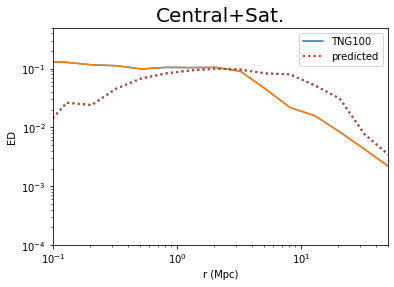

In [26]:
plt.figure()
plot(rbins[1:] + rbins[:-1],  (ed1h+ed2h),label='TNG100')
plot(rbins[1:] + rbins[:-1],  (ed1h))
plot(rbins[1:] + rbins[:-1],  (ed2h))

plot(rbins[1:] + rbins[:-1],  (ed1h2),':',label='predicted',lw=2)
plot(rbins[1:] + rbins[:-1],  (ed2h2),'--',lw=2)
plot(rbins[1:] + rbins[:-1],  (ed1h2+ed2h2),':',lw=2)
ylim(0.0001, 0.5)
legend()
title('step:' +str(step))
ylabel('ED')
xlabel('r (Mpc)')
xscale('log')
yscale('log')
xlim(0.1,50)
title('Central+Sat.', fontsize=20)